# Praca domowa 3
## Karol Degórski

### Wytrenowanie skutecznego modelu

Będziemy próbowali wyjaśnić predykcję sieci ResNet18 wytrenowaną na zbiorze large scale fish (9000 obrazów 224x224 pogrupowanych w 9 kategoriach)

In [2]:
import numpy as np 
import pandas as pd
import os

In [3]:
!pip install timm

     |████████████████████████████████| 431 kB 26.0 MB/s 


In [4]:
# https://www.kaggle.com/code/andrescastroitm/fish-classification-with-pytorch-image-models/notebook
import timm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

from PIL import Image

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [5]:
class Chooser:
    def __init__(self):
        pass
    def __call__(self, path):
        if 'GT' in path:
            return False
        return True

def loader(path):
    return Image.open(path).rotate(45)

In [8]:
! pip install kaggle

In [9]:
! mkdir ~/.kaggle

In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets download crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:14<00:00, 237MB/s]
100% 3.24G/3.24G [00:14<00:00, 242MB/s]


In [17]:
!unzip a-large-scale-fish-dataset.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00448.png  
  inflating: Fish_Dataset

In [6]:
transform=transforms.Compose([transforms.Resize((224,224)),
                             transforms.ToTensor()])

In [19]:
T = torchvision.datasets.ImageFolder('Fish_Dataset/Fish_Dataset/',
                                    is_valid_file=Chooser(), transform = transform)

In [27]:
T

Dataset ImageFolder
    Number of datapoints: 18000
    Root location: Fish_Dataset/Fish_Dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [21]:
Train,Test = torch.utils.data.random_split(T, (round(0.8*len(T)), round(0.2*len(T)) ))

In [22]:
BATCH_SIZE = 32

train_loader = DataLoader(Train, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(Test, batch_size=BATCH_SIZE, drop_last=True)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [24]:
model = timm.create_model('resnet18', pretrained=True, num_classes=9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [25]:
model.train()

model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
num_epochs = 2
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    print(f"Start of Epoch {epoch+1} of {num_epochs}")
    total_train = 0
    correct_train = 0
    
    for images, labels in train_loader:
        print('*', end='')
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        #train = Variable(images.view(BATCH_SIZE, 3, 224, 224))
        #labels = Variable(labels)
        
        # Forward pass 
        outputs = model(images)
        loss = error(outputs, labels)
        
        predictions = torch.max(outputs, 1)[1].to(device)
        correct_train += (predictions == labels).sum()
        total_train += len(labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    print(f"\nEpoch {epoch+1} of {num_epochs} Done!")
    
    # Testing the model
    
        
    total = 0
    correct = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)

#         test = Variable(images.view(BATCH_SIZE, 3, 224, 224))

        outputs = model(images)

        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()

        total += len(labels)

    accuracy = correct * 100 / total
    accuracy_train = correct_train * 100 / total_train
    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)
        
        
    print("Epoch: {}, Loss: {}, Accuracy_test: {:.4f}%, Accuracy_train: {:.4f}%".format(epoch+1, loss.data, accuracy,accuracy_train))

Start of Epoch 1 of 2
******************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Epoch 1 of 2 Done!
Epoch: 1, Loss: 0.8569225668907166, Accuracy_test: 88.9230%, Accuracy_train: 79.7222%
Start of Epoch 2 of 2
****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [30]:
torch.save(model.state_dict(), "model.pth")

Widzimy, że udało się wytrenować model - accuracy na zbiorze testowym osiągnęło poziom 91% . Zarówno na zbiorze treningowym jak i testowym accuracy cały czas rośnie - model nie zdążył sie przeczuczyć. Ze względu na bardzo długi czas uczenia (1 epoka - 1 godzina) oraz zbliżającym się terminie oddania pracy domowej poprzestajemy na 2 epokach

### Wizualizacja wybranych zdjęć

In [32]:
!pip install shap captum torchinfo

     |████████████████████████████████| 564 kB 28.5 MB/s 
     |████████████████████████████████| 1.4 MB 42.4 MB/s 


In [38]:
from captum.attr import visualization
from skimage import segmentation
def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

In [34]:
def mask(image):
  return segmentation.slic(
    image.permute(1, 2, 0).mean(axis=2), 
    n_segments=100, 
    compactness=0.1, 
    start_label=0,
  )

In [35]:
preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

#### LIME

In [36]:
from captum.attr import Lime
explainer = Lime(model)

def attr(i):
  return explainer.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(images[i])),
    show_progress=False
  )

<function matplotlib.pyplot.show>

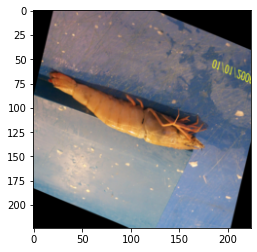

In [56]:
plt.imshow(images[3].permute(1, 2, 0))
plt.show

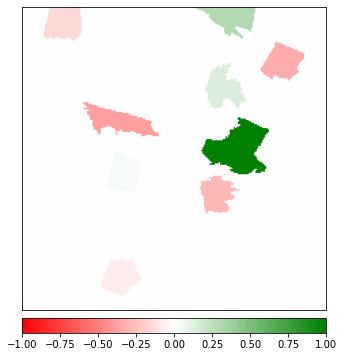

In [41]:
show_attr(attr(3)[0])

#### Integrated Gradients

In [42]:
from captum.attr import IntegratedGradients
exp_ig = IntegratedGradients(model)

In [43]:
def attr_ig(i):
   return exp_ig.attribute(
       preprocess(images[i].unsqueeze(0)), target=labels[i])

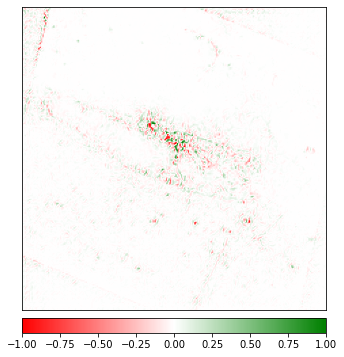

In [44]:
show_attr(attr_ig(3)[0])


#### SHAP

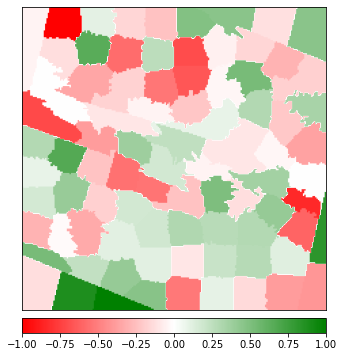

In [46]:
from captum.attr import KernelShap
exp_ks = KernelShap(model)

def attr_ks(i):
  return exp_ks.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(images[i])),
    show_progress=False
  )

show_attr(attr_ks(3)[0])

#### Użyjemy teraz tych algorytmów na 5 innych zdjęciach

In [106]:
def explain(number):
  plt.imshow(images[number].permute(1, 2, 0))
  show_attr(attr(number)[0])
  show_attr(attr_ig(number)[0])
  show_attr(attr_ks(number)[0])

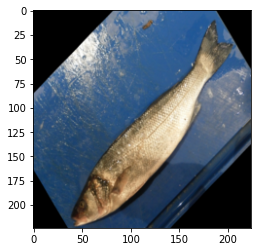

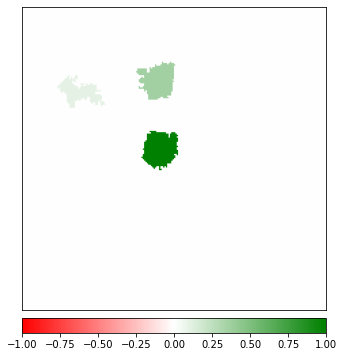

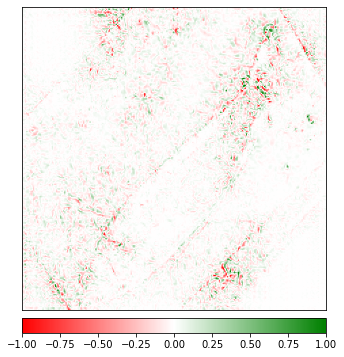

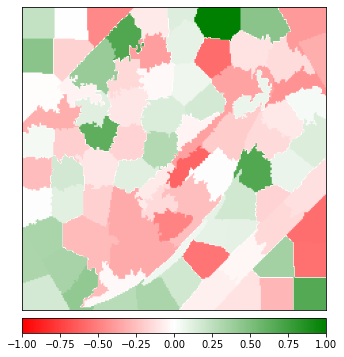

In [107]:
explain(7)

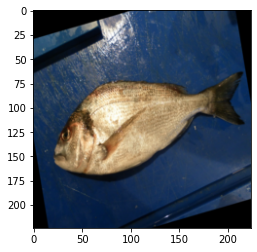

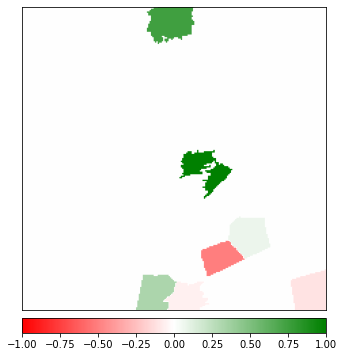

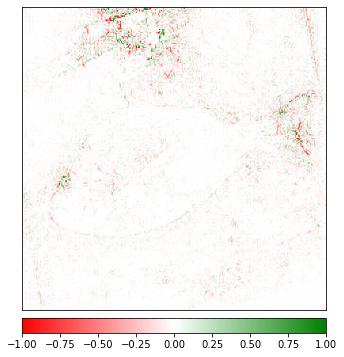

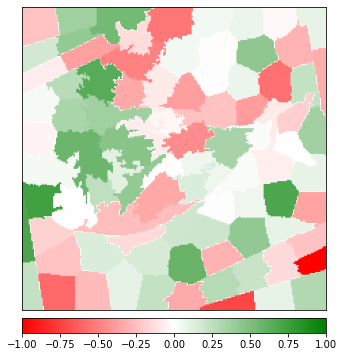

In [108]:
explain(8)

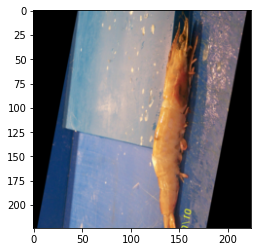

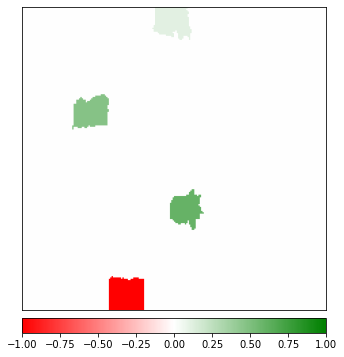

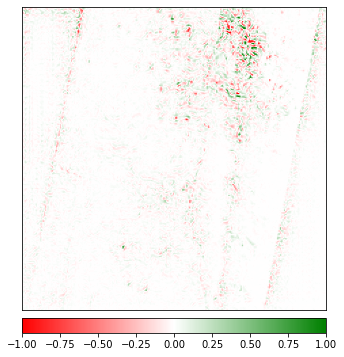

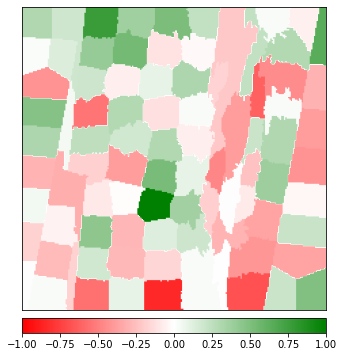

In [110]:
explain(10)

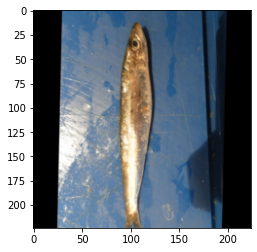

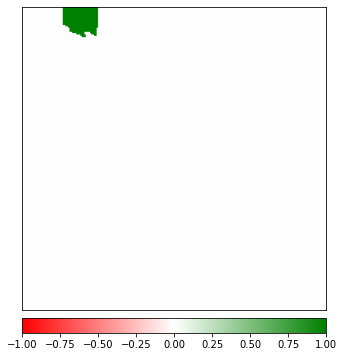

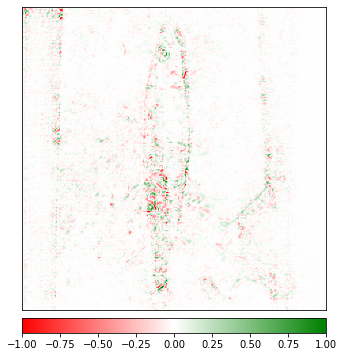

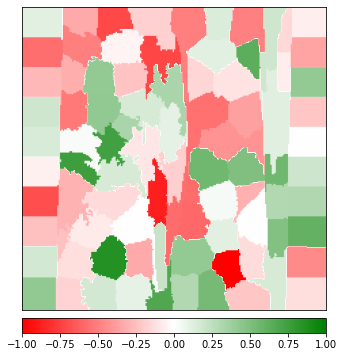

In [111]:
explain(11)

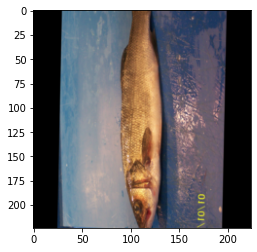

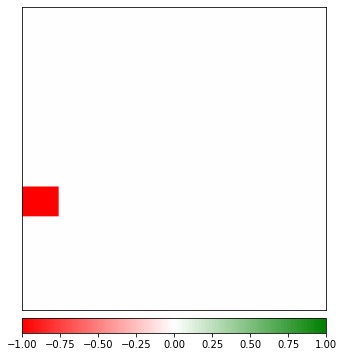

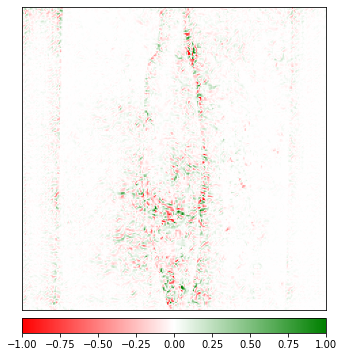

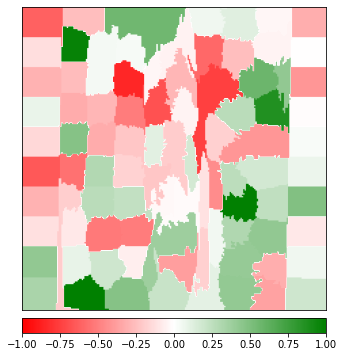

In [116]:
explain(16)

### Wizualizacja błędnie zaklasyfikowanych zdjęć

Z uwagi na zbliżone kształty ryb trudno osobie niezainteresowanej wędkarstwem stwierdzić czy ryba została zaklasyfikowana prawidłowo

In [146]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val][0]

Predicted: Striped Red Mullet, real: Red Mullet


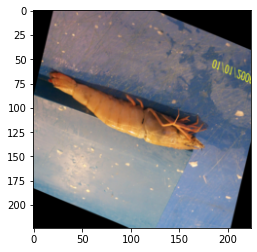

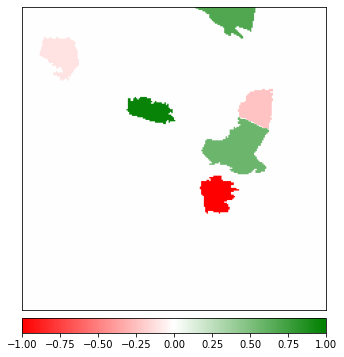

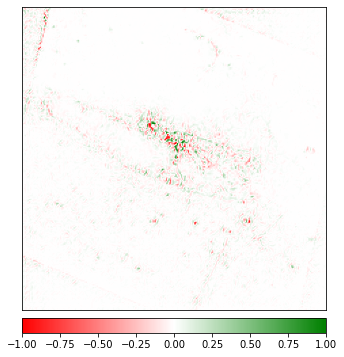

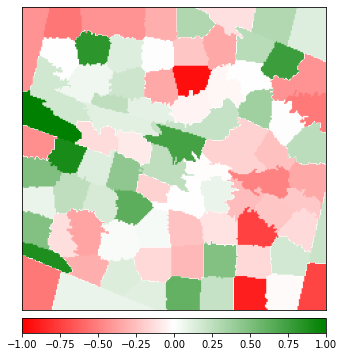

Predicted: Gilt-Head Bream, real: Red Sea Bream


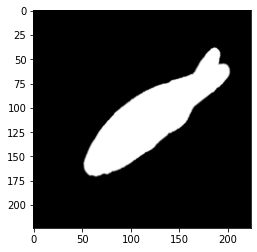

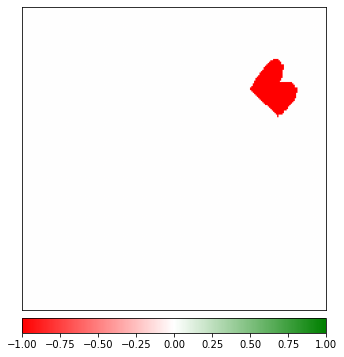

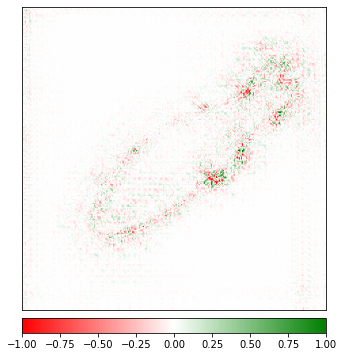

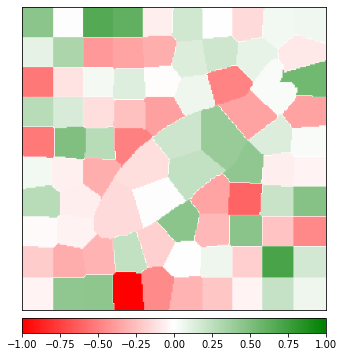

Predicted: Gilt-Head Bream, real: Red Sea Bream


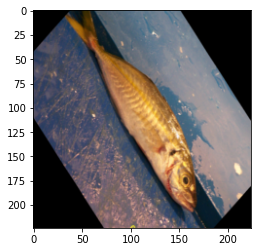

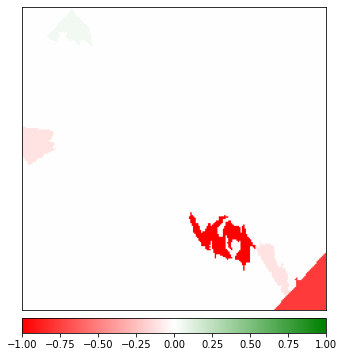

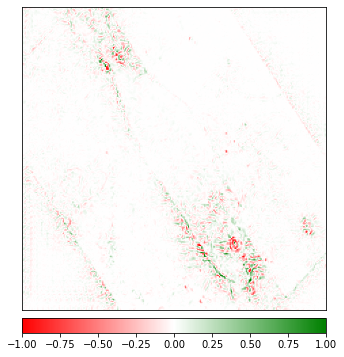

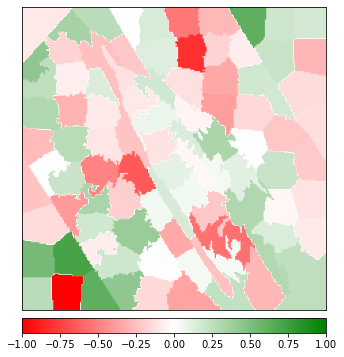

In [147]:
from timm.loss import LabelSmoothingCrossEntropy 
criterion = LabelSmoothingCrossEntropy()

test_loss = 0.0
iter = 0;
for data, target in test_loader:
  with torch.no_grad(): 
      output = model(data)
      loss = criterion(output, target)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))

  correct = np.squeeze(correct_tensor.cpu().numpy())
     
  for i in range(len(correct)):
    if(correct[i] == False):
      print(f'Predicted: {get_keys_from_value(T.class_to_idx, pred[i])}, real: {get_keys_from_value(T.class_to_idx, target[i])}')
      explain(i)
      iter = iter+1
    if (iter == 3):
      break
  if (iter == 3):
      break

Tak jak już wyżej zauważyliśmy problematyczne jest wytłumaczenie różnic pomiędzy rybami:
- w pierwszym przypadku model pomylił gatunki barweny (Striped Red Mullet i Red Mullet) 
- w drugim i trzecim przypaku pomylono doradę z pagrusem

### Wnioski

- wytrenowanie sieci typu ResNet jest czasochłonne zwłaszcza przy dużym zbiorze danych, ale z drugiej strony takie sieci mają dużą skuteczność klasyfikacji
- nie istnieje idealna metoda do wyjaśniania modeli klasyfikacji obrazów
- jeśli obrazy są podobne to trudno jest pokazać w czytelny sposób co istotnie odróżnia od siebie zdjęcia (zwłaszcza osobie niebędącej znawcą ryb)
- najlepsze rezultaty uzyskaliśmy metodą Integrated Gradients, a najsłabsze metodą Lime